# Hinf Analysis and Synthesis

In [1]:
%reset -f

# Python Control Systems Library
# https://python-control.readthedocs.io/en/latest/index.html

from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import control
except ModuleNotFoundError:
    print("Could not find control - installing")
    !pip install control

try:
    import slycot
except ModuleNotFoundError:
    print("Could not find slycot - installing")
    !pip install slycot

from control import tf, mixsyn, feedback, step_response
!pwd

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
from numpy import linalg as LA
r2d = 180/np.pi

Running Python: 3.10.8
/home/jovyan/work


# Example in 27

In [2]:
"""robust_siso.py

Demonstrate mixed-sensitivity H-infinity design for a SISO plant.

Based on Example 2.11 from Multivariable Feedback Control, Skogestad
and Postlethwaite, 1st Edition.
"""
s = tf([1, 0], 1)
# the plant
g = 200/(10*s + 1) / (0.05*s + 1)**2
# disturbance plant
gd = 100/(10*s + 1)

# first design
# sensitivity weighting
M = 1.5
wb = 10
A = 1e-4
ws1 = (s/M + wb) / (s + wb*A)
# KS weighting
wu = tf(.15, 1)
k1, cl1, info1 = mixsyn(g, ws1, wu)
print(f'First design gamma = {info1[0]:3.2f}')

# sensitivity (S) and complementary sensitivity (T) functions for
# design 1
s1 = feedback(1, g*k1)
t1 = feedback(g*k1, 1)

First design gamma = 0.97


In [3]:
# second design
# this weighting differs from the text, where A**0.5 is used; if you use that,
# the frequency response doesn't match the figure.  The time responses
# are similar, though.
ws2 = (s/M ** 0.5 + wb)**2 / (s + wb*A)**2
# the KS weighting is the same as for the first design
k2, cl2, info2 = mixsyn(g, ws2, wu)
print(f'Second design gamma = {info2[0]:3.2f}')
# S and T for design 2
s2 = feedback(1, g*k2)
t2 = feedback(g*k2, 1)

Second design gamma = 1.28


In [4]:
# frequency response
omega = np.logspace(-2, 2, 101)
ws1mag, _, _ = ws1.frequency_response(omega)
s1mag, _, _ = s1.frequency_response(omega)
ws2mag, _, _ = ws2.frequency_response(omega)
s2mag, _, _ = s2.frequency_response(omega)

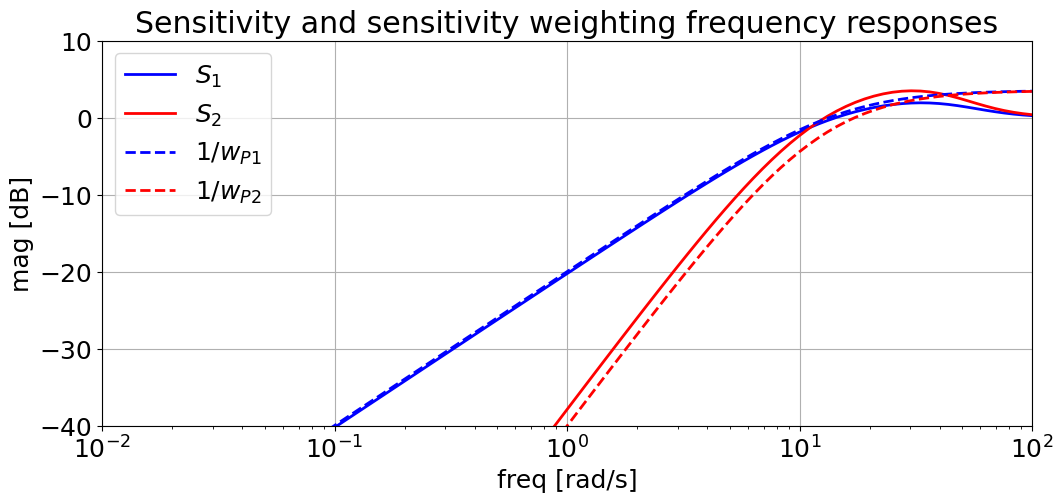

In [5]:
plt.figure(1,figsize=(12,5))
# text uses log-scaled absolute, but dB are probably more familiar to most control engineers
plt.semilogx(omega, 20*np.log10(s1mag.flat), 'b', label='$S_1$')
plt.semilogx(omega, 20*np.log10(s2mag.flat), 'r', label='$S_2$')
# -1 in logspace is inverse
plt.semilogx(omega, -20*np.log10(ws1mag.flat), 'b--', label='$1/w_{P1}$')
plt.semilogx(omega, -20*np.log10(ws2mag.flat), 'r--', label='$1/w_{P2}$')

plt.ylim([-40, 10])
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.ylabel('mag [dB]')
plt.legend()
plt.title('Sensitivity and sensitivity weighting frequency responses')
plt.show()

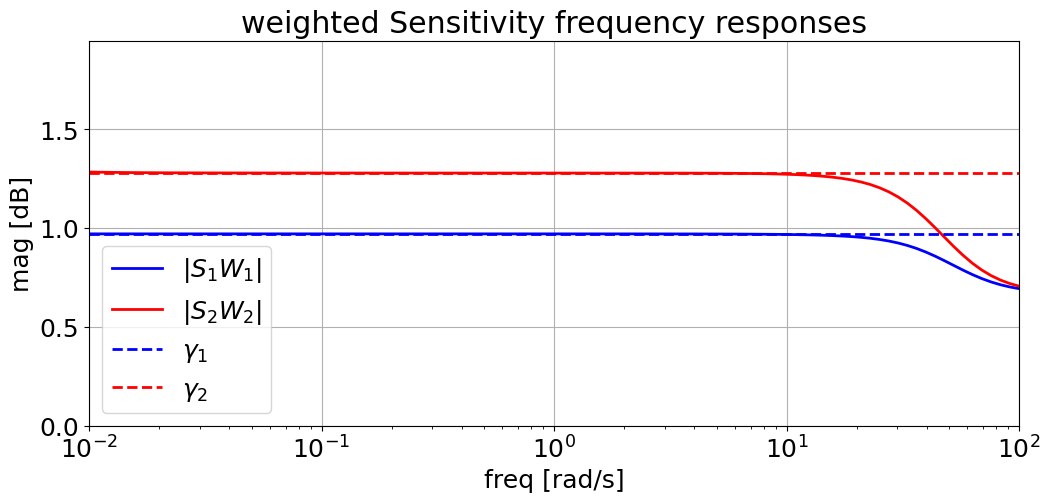

In [6]:
plt.figure(1,figsize=(12,5))
# text uses log-scaled absolute, but dB are probably more familiar to most control engineers
plt.semilogx(omega, (s1mag*ws1mag.flat), 'b', label='$|S_1W_1|$')
plt.semilogx(omega, (s2mag*ws2mag.flat), 'r', label='$|S_2W_2|$')
plt.semilogx([omega[0],omega[-1]], ([info1[0], info1[0]]), 'b--', label='$\gamma_1$')
plt.semilogx([omega[0],omega[-1]], ([info2[0], info2[0]]), 'r--', label='$\gamma_2$')

plt.ylim([0, 1.5*np.round(info2[0],1)])
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.ylabel('mag [dB]')
plt.legend()
plt.title('weighted Sensitivity frequency responses')
plt.show()

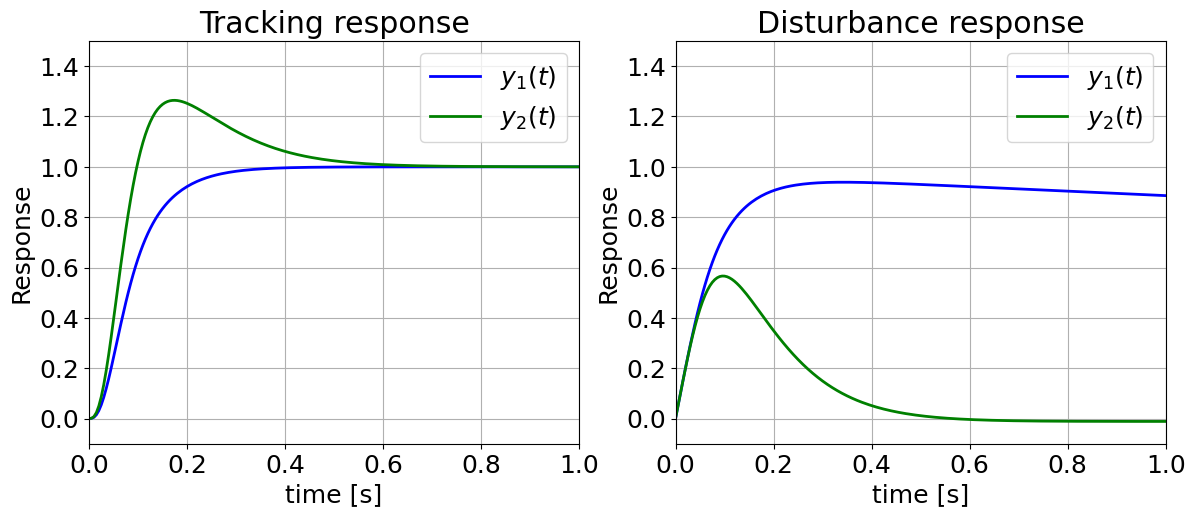

In [7]:
# time response
time = np.linspace(0, 1, 201)
_, y1 = step_response(t1, time)
_, y2 = step_response(t2, time)

# gd injects into the output (that is, g and gd are summed), and the
# closed loop mapping from output disturbance->output is S.
_, y1d = step_response(s1*gd, time)
_, y2d = step_response(s2*gd, time)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(12,5))
fig.tight_layout()
ax1.plot(time, y1, label='$y_1(t)$')
ax1.plot(time, y2, label='$y_2(t)$')
ax1.set_ylim([-0.1, 1.5])
ax1.set_xlim([0, 1])
ax1.set_xlabel('time [s]')
ax1.set_ylabel('Response')
ax1.legend()
ax1.set_title('Tracking response')

ax2.plot(time, y1d, label='$y_1(t)$')
ax2.plot(time, y2d, label='$y_2(t)$')

ax2.set_ylim([-0.1, 1.5])
ax2.set_xlim([0, 1])
ax2.set_xlabel('time [s]')
ax2.set_ylabel('Response')
ax2.legend()
ax2.set_title('Disturbance response')

plt.show()